In [1]:
from ml_util import *

In [2]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("house_prices.csv")

X = df.drop(columns="SalePrice")
y = df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
index_drop = X_train.query("GrLivArea > 4500").index

X_train = X_train.drop(index=index_drop)
y_train = y_train.drop(index=index_drop)

X_train_num = X_train.select_dtypes(include=np.number).drop(columns="Id")
X_train_num_full = X_train_num.dropna(axis=1)

X_test_num_full = X_test[X_train_num_full.columns]

lasso_pipe = Pipeline([
    ("pf", PolynomialFeatures(degree=2, include_bias=False)),
    ("mms", MinMaxScaler()),
    ("lasso", Lasso(alpha=50, max_iter=2000))
]).fit(X_train_num_full, y_train)

_ = reg_metrics_train_test(lasso_pipe, X_train_num_full, y_train, X_test_num_full, y_test)



Metricas de avaliação (dados de treino):

R^2: 0.93
MAE: 14802.68
RMSE: 21121.71
MAPE: 8.74%
------------------------------------

Metricas de avaliação (dados de teste):

R^2: 0.91
MAE: 17768.14
RMSE: 26937.40
MAPE: 10.61%


In [4]:
from sklearn.model_selection import KFold

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
idcs_train, idcs_val = list(kf.split(X_train_num_full))[0]

In [7]:
from sklearn.model_selection import cross_validate

In [8]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

lasso_pipe = Pipeline([
    ("pf", PolynomialFeatures(degree=2, include_bias=False)),
    ("mms", MinMaxScaler()),
    ("lasso", Lasso(alpha=50, max_iter=2000))
])

result_cv = cross_validate(lasso_pipe, X_train_num_full, y_train, cv=kf, n_jobs=-1, return_train_score=True, scoring="neg_mean_absolute_error")


In [9]:
df_results_cv = pd.DataFrame(result_cv).abs()

df_results_cv

,fit_time,score_time,test_score,train_score
0,6.456759,0.015132,18795.750016,14530.614940
1,3.869794,0.028501,15965.555977,14608.206905
2,6.322771,0.025678,16607.321261,14603.621081
3,3.780216,0.035998,16015.145534,14830.744169
4,6.331311,0.046761,15666.914764,14668.677423
5,2.982693,0.012864,15188.159049,14967.141625
6,3.697891,0.007990,18674.906364,14509.634894
7,3.882262,0.017654,16036.501778,14686.538213
8,3.789312,0.011298,14604.100127,14897.769226
9,2.284235,0.010439,15809.645468,14671.537688


In [10]:
df_results_cv[["test_score", "train_score"]].describe()

,test_score,train_score
count,10.000000,10.000000
mean,16336.400034,14697.448616
std,1372.996822,153.522971
min,14604.100127,14509.634894
25%,15702.597440,14604.767537
50%,15990.350756,14670.107556
75%,16464.616390,14794.692680
max,18795.750016,14967.141625


<Axes: xlabel='test_score', ylabel='Count'>

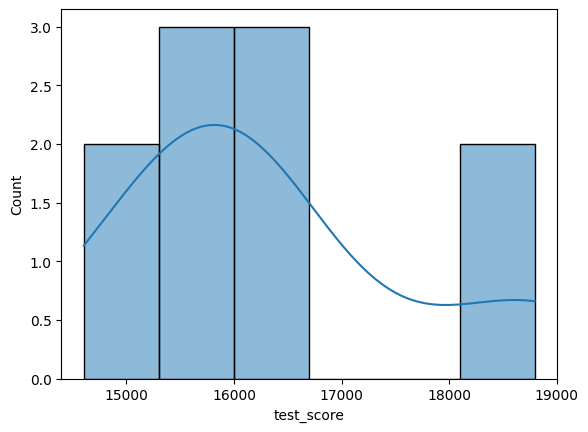

In [11]:
sns.histplot(data=df_results_cv, x="test_score", kde=True)

<Axes: xlabel='train_score', ylabel='Count'>

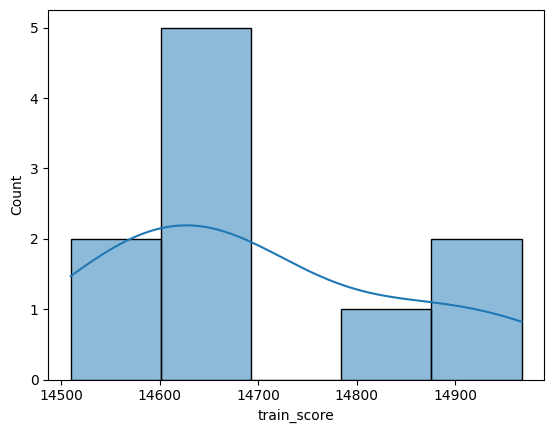

In [12]:
sns.histplot(data=df_results_cv, x="train_score", kde=True)

In [13]:
def vizualizar_cv(estimator, X, y, scoring, n_splits):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    result_cv = cross_validate(estimator, X, y, cv=kf, n_jobs=-1, return_train_score=True, scoring=scoring)

    df_results_cv = pd.DataFrame(result_cv).abs()

    display(df_results_cv[["test_score", "train_score"]].describe())

    plt.title("Distribuição amostral de metricas de validação cruzada")
    sns.histplot(data=df_results_cv, x="test_score", kde=True, color="orange", label="test")
    sns.histplot(data=df_results_cv, x="train_score", kde=True, label="train")
    plt.legend()
    plt.show()

,test_score,train_score
count,10.000000,10.000000
mean,16336.400034,14697.448616
std,1372.996822,153.522971
min,14604.100127,14509.634894
25%,15702.597440,14604.767537
50%,15990.350756,14670.107556
75%,16464.616390,14794.692680
max,18795.750016,14967.141625


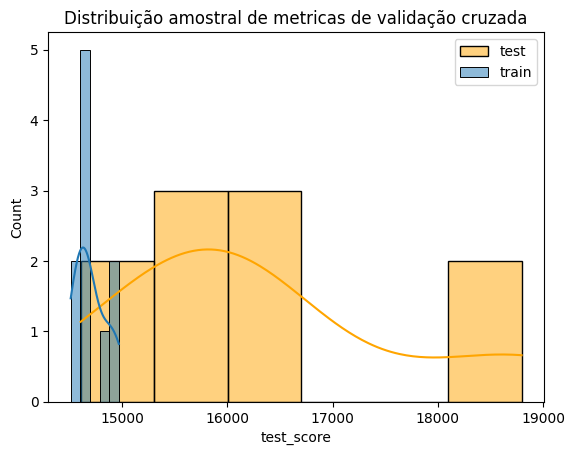

In [14]:
vizualizar_cv(lasso_pipe, X_train_num_full, y_train, "neg_mean_absolute_error", 10)

,test_score,train_score
count,30.000000,30.000000
mean,16370.254482,14767.568058
std,2686.816692,86.714413
min,10188.125138,14583.247122
25%,14583.775965,14722.980134
50%,16550.950157,14783.433766
75%,17869.641140,14822.241180
max,21742.613884,14946.690003


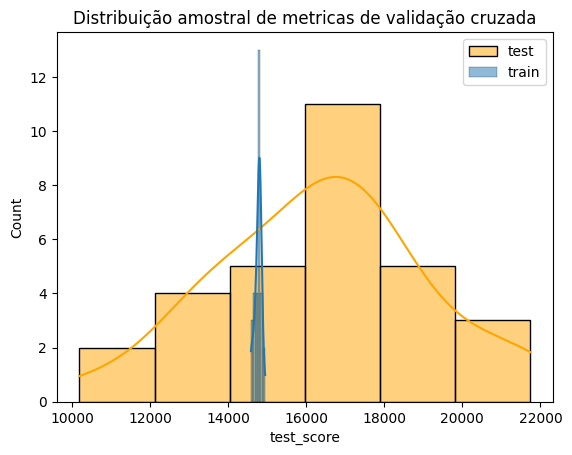

In [15]:
vizualizar_cv(lasso_pipe, X_train_num_full, y_train, "neg_mean_absolute_error", 30)

In [16]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

lasso_pipe = Pipeline([
    ("pf", PolynomialFeatures(degree=2, include_bias=False)),
    ("mms", MinMaxScaler()),
    ("lasso", Lasso(alpha=50, max_iter=2000))
])

result_cv = cross_validate(
    lasso_pipe, X_train_num_full, y_train, 
    cv=kf, n_jobs=-1, return_train_score=True, 
    scoring={"MAE": "neg_mean_absolute_error", 
            "RMSE": "neg_root_mean_squared_error", 
            "MAPE": "neg_mean_absolute_percentage_error",
            "R^2": "r2"})

df_results_cv = pd.DataFrame(result_cv).abs()

df_results_cv

,fit_time,score_time,test_MAE,train_MAE,test_RMSE,train_RMSE,test_MAPE,train_MAPE,test_R^2,train_R^2
0,10.916322,0.048325,18795.750016,14530.614940,26086.544434,20688.050507,0.105910,0.086278,0.908343,0.926293
1,6.547675,0.067289,15965.555977,14608.206905,26957.891628,20538.232805,0.090541,0.086557,0.862224,0.930178
2,10.835118,0.039686,16607.321261,14603.621081,24733.773416,20751.842523,0.105783,0.085869,0.903627,0.927413
3,5.785599,0.084474,16015.145534,14830.744169,23603.680930,21260.268201,0.094065,0.087366,0.892998,0.925413
4,9.637934,0.052577,15666.914764,14668.677423,21996.606692,21015.910953,0.085393,0.087080,0.908586,0.926837
5,5.107656,0.056410,15188.159049,14967.141625,23431.805099,21139.292250,0.090926,0.088108,0.908423,0.924964
6,5.459251,0.058988,18674.906364,14509.634894,26153.314073,20768.902811,0.110031,0.085360,0.906430,0.925968
7,5.837286,0.056764,16036.501778,14686.538213,21473.062185,21109.634565,0.095677,0.086528,0.910335,0.926532
8,4.481058,0.034016,14604.100127,14897.769226,20273.548633,21218.954688,0.086776,0.087936,0.920553,0.925707
9,4.237802,0.020691,15809.645468,14671.537688,24743.865170,20719.051908,0.088139,0.087188,0.899292,0.927880


In [17]:
from sklearn.linear_model import LassoCV

In [23]:
kf = KFold(n_splits=30, shuffle=True, random_state=42)

lasso_pipe = Pipeline([
    ("pf", PolynomialFeatures(degree=2, include_bias=False)),
    ("mms", MinMaxScaler()),
    ("lasso", LassoCV(alphas=np.linspace(20, 30, 100), cv=kf, max_iter=3000, n_jobs=-1))
]).fit(X_train_num_full, y_train)

c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 658606165.7658691, tolerance: 636342303.5991907
  model = cd_fast.enet_coordinate_descent_gram(


In [24]:
lasso_pipe[-1].alpha_

24.693877551020407